<a href="https://colab.research.google.com/github/seojeongbin/web1/blob/master/%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C1_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 조선/해양산업 디지털 혁신을 위한 BIG DATA / AI 대학생 경진대회
* CNC 데이터를 통한 마킹시간, 절단시간 예측하기
* https://www.youtube.com/watch?v=Q_MbN-vu_2w : 자전거 예측
* https://jujuen.tistory.com/230?category=824363 : 전처리 팁 
* 영어텍스트들이 많은경우에 대한 전처리 : 과제해설 참고

## 시작 전 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
'''
!sudo apt-get install -y fonts-nanum

!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
-> 현부형이 주신 코드인데 나는 그래도 한글이 안나오네 ㅜㅜ
'''

"\n!sudo apt-get install -y fonts-nanum\n\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf\n\nplt.rc('font', family='NanumBarunGothic')\n-> 현부형이 주신 코드인데 나는 그래도 한글이 안나오네 ㅜㅜ\n"

## 1. 데이터 불러오기

### .shape랑 .head 등으로 형태와 대표 몇가지 데이터 확인.
* 알아도 습관처럼 꼭하기

In [3]:
data = pd.read_csv("대회데이터.csv", encoding='cp949')
data.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,5,6,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(162326, 10)

In [4]:
data.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,절단장비,마킹시간,절단시간
1,1,46,21.9,30,DZB,1,23,PL233,194,827
2,2,33.9,111.8,12,A,46,23,PL233,324,2906
3,3,49.5,33.5,13,A,2,23,PL234,241,1003
4,4,75.7,174.9,13,A,35,23,PL233,483,4412


In [5]:
# 설명행 삭제 (첫행삭제)
data = data.drop(0,0)
data.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
1,1,46,21.9,30,DZB,1,23,PL233,194,827
2,2,33.9,111.8,12,A,46,23,PL233,324,2906
3,3,49.5,33.5,13,A,2,23,PL234,241,1003
4,4,75.7,174.9,13,A,35,23,PL233,483,4412
5,5,66.5,66.6,13,A,7,23,PL233,331,1601


## 2. 데이터 확인 및 시각화 

### 데이터 확인

* .info 통해서 데이터타입 .astype(float) 이런식으로 타입변경
* 말안되는 오류 같은거 여기서 미리 바꿔놓기
* .isnull().sum() 으로 null 값 확인. 빈칸있으면 과학적인 방법으로 채워넣야함.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162325 entries, 1 to 162325
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   C1      162325 non-null  object
 1   C2      162325 non-null  object
 2   C3      162325 non-null  object
 3   C4      162325 non-null  object
 4   C5      162325 non-null  object
 5   C6      162325 non-null  object
 6   C7      162325 non-null  object
 7   C8      162325 non-null  object
 8   C9      162325 non-null  object
 9   C10     162325 non-null  object
dtypes: object(10)
memory usage: 13.6+ MB


In [7]:
data.C2 = data.C2.astype(float)
data.C3 = data.C3.astype(float)
data.C4 = data.C4.astype(float)
data.C6 = data.C6.astype(float)
data.C9 = data.C9.astype(float)
data.C10 = data.C10.astype(float)
#data.C5 = data.C5.astype(float)
data.C7 = data.C7.astype(float)
#data.C8 = data.C8.astype(float)


### 시각화
* 범주형 변수 분석 그림그리기 
* 타겟값 상위몇프로, 그거 떼내서 특징분석 그거 과제해설 참고
* 피쳐와 타겟값에 따른 다이어그램 식 연관성 파악(자전거, 기온예측과제)
* 변수가 타겟값에 미치는 수준 시각화(자전거, 기온예측과제)
* scatter 엔드투엔드 방식 참고 
* corr 직사각형 테이블 시각화
  * 위 과정으로 변수간 상관성 파악후 삭제 피쳐 등 결정


### 범주형 변수 빈도 분석 

In [8]:
def bar_plot(x): # 입력값을 피처로 받아서 빈도 다이어그램을 만들어주는 그래프 함수 정의
  var = data[x]
  var_value = var.value_counts()
  plt.figure(figsize=(40,6))
  plt.bar(var_value.index, var_value)
  plt.xticks(var_value.index, var_value.index.values)
  plt.ylabel("Frq")
  plt.title(x)
  plt.show()

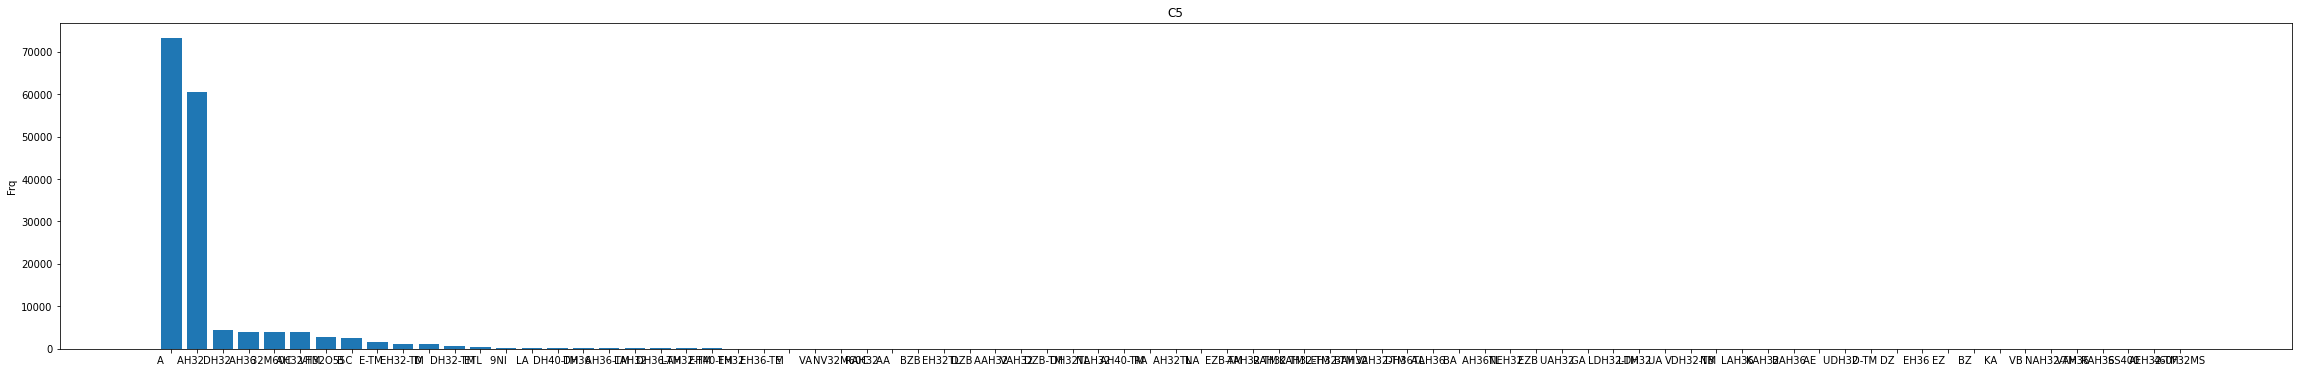

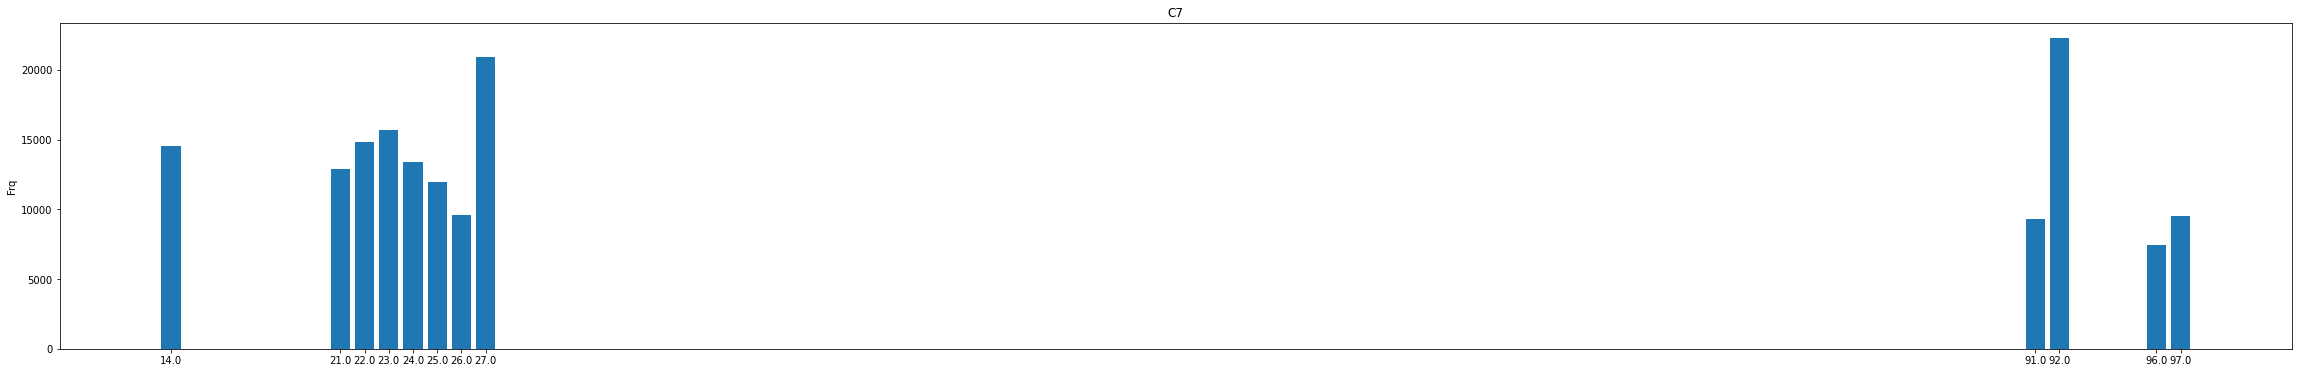

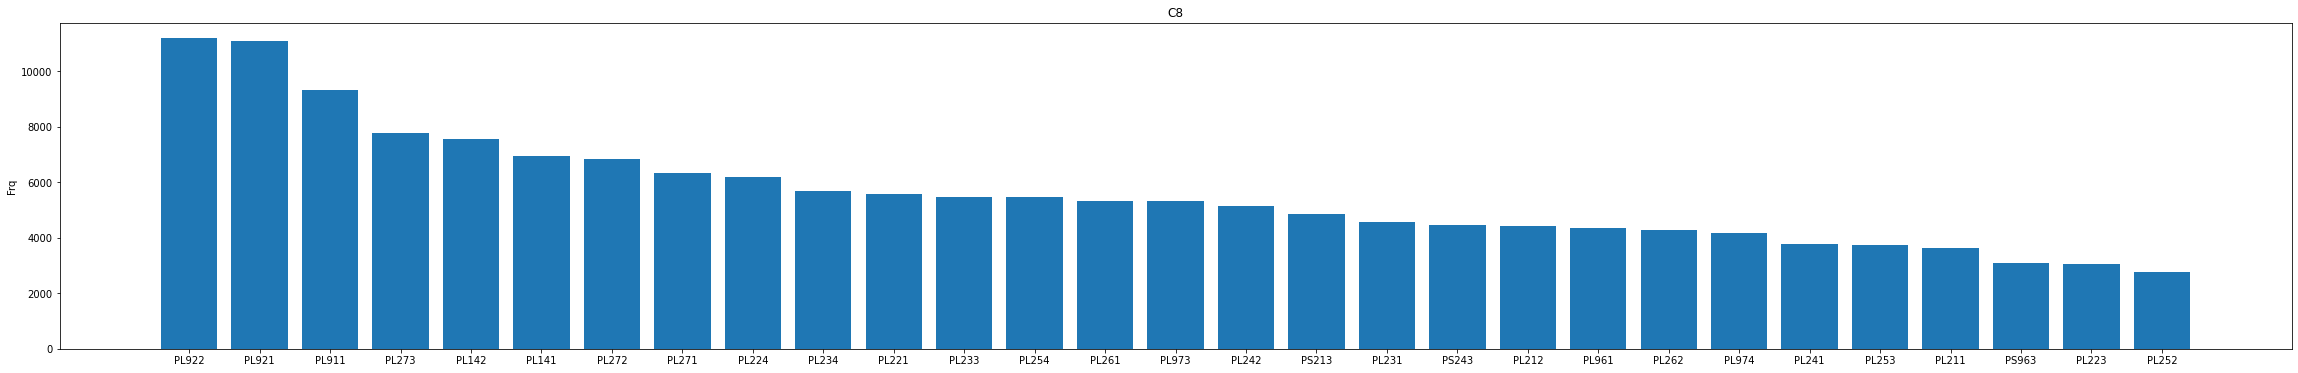

In [9]:
category1 = ["C5", "C7", "C8"] # 범주형 피쳐라고 생각하는 애들을 여기에 넣고

for c in category1: # 반복해서 출력해줌. 
  bar_plot(c)

* C5(철판재질) : 빈도가 균등하지않고 특정 재질에 매우 몰려있음. 이를 감안하여 변수처리가 필요할듯 해보임
* C7(작업장) : 비교적 빈도가 균등함. 하지만 어느정도 몰려있는 작업장이 존재함
* C8(절단장비) : 922번 -> 252번 작업장으로 갈수록 비례적으로 감소하는 경향을 보임.
  * 위 변수들의 특징을 감안하여 인코딩 방식을 선정할 필요가 있을듯 함

### 전반적 데이터 분포확인

In [10]:
data.describe()

,C2,C3,C4,C6,C7,C9,C10
count,162325.000000,162325.000000,162325.000000,162325.000000,162325.000000,1.623250e+05,162325.000000
mean,77.808576,73.842234,17.455914,13.585350,43.923154,8.361304e+02,2188.729801
std,48.093706,53.217750,4.500207,20.712078,32.507921,4.154486e+04,2183.228269
min,3.200000,1.100000,6.000000,1.000000,14.000000,0.000000e+00,0.000000
25%,45.300000,40.900000,14.500000,1.000000,22.000000,2.390000e+02,1065.000000
50%,68.300000,52.700000,17.000000,4.000000,25.000000,3.790000e+02,1593.000000
75%,98.800000,93.000000,20.000000,18.000000,91.000000,5.480000e+02,2773.000000
max,524.400000,621.300000,40.000000,416.000000,97.000000,6.157364e+06,348262.000000


In [11]:
# 절단시간이 많이 소요되는 경우에 대한 심층분석
data['절단시간'] =  [ 1 if i >= 2773.0 else 0 for i in data.C10] 
data['절단시간'].value_counts()

0    121723
1     40602
Name: 절단시간, dtype: int64

In [12]:
cutting_time = data[data['절단시간']==1]
cutting_time.describe()

,C2,C3,C4,C6,C7,C9,C10,절단시간
count,40602.000000,40602.000000,40602.000000,40602.000000,40602.000000,40602.00000,40602.000000,40602.0
mean,80.183681,141.700148,16.984299,31.497783,42.630856,626.46281,4553.885695,1.0
std,40.605845,60.604679,4.499576,25.821178,31.786729,953.82742,3253.166584,0.0
min,4.200000,4.600000,6.000000,1.000000,14.000000,0.00000,2773.000000,1.0
25%,54.400000,104.825000,14.000000,13.000000,22.000000,375.00000,3254.000000,1.0
50%,77.300000,131.100000,16.000000,26.000000,24.000000,521.00000,3913.000000,1.0
75%,98.400000,165.900000,19.000000,44.000000,91.000000,710.00000,5046.000000,1.0
max,448.500000,621.300000,40.000000,416.000000,97.000000,63781.00000,348262.000000,1.0


### 절단시간소요에 대한 심층분석
* 소요시간 75프로 (많이 소요되는 시간의 상위 25프로) 에 대해서 새로만든 df에 대해서도
* 50~75프로 보다 75 ~ 100(max) 구간이 훨씬 큰 것으로 보아 c10(절단시간)은 선형보단 지수함수의 형태를 가질것으로 예상된다

In [13]:
del data['절단시간']

### 서로간의 상관성 파악 

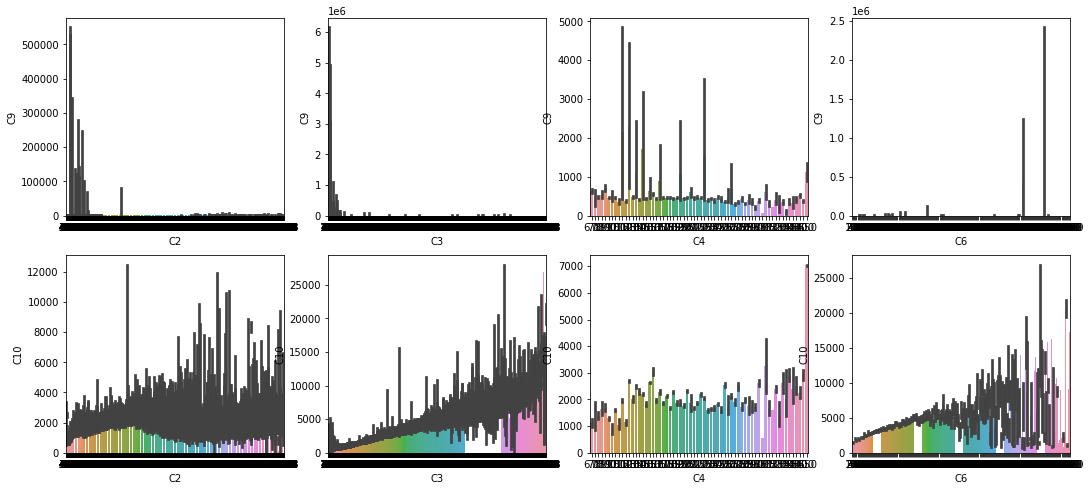

In [14]:
figure, ((ax1,ax2,ax3, ax4), (ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4)
figure.set_size_inches(18,8)

sns.barplot(data=data, x="C2", y="C9", ax=ax1)
sns.barplot(data=data, x="C3", y="C9", ax=ax2)
sns.barplot(data=data, x="C4", y="C9", ax=ax3)
sns.barplot(data=data, x="C6", y="C9", ax=ax4)
sns.barplot(data=data, x="C2", y="C10", ax=ax5)
sns.barplot(data=data, x="C3", y="C10", ax=ax6)
sns.barplot(data=data, x="C4", y="C10", ax=ax7)
sns.barplot(data=data, x="C6", y="C10", ax=ax8)


* 마킹길이, 절단길이가 짧으면 당연하게도 마킹시간이 적은양상을 가졌다
* 철판두께와 절단갯수와 마킹시간에 대해서는 크게 연관성이 없었다
* 절단시간의 경우, 마킹길이, 절단길이, 절단갯수와 어느정도 연관성을 보였다
  * 철판두께와 절단시간은 오히려 연관성이 없어서 인상적이였다

[Text(0, 0.5, 'cutting_time'),
 Text(0.5, 0, 'cutting_counts'),
 Text(0.5, 1.0, 'c.c -> c.t')]

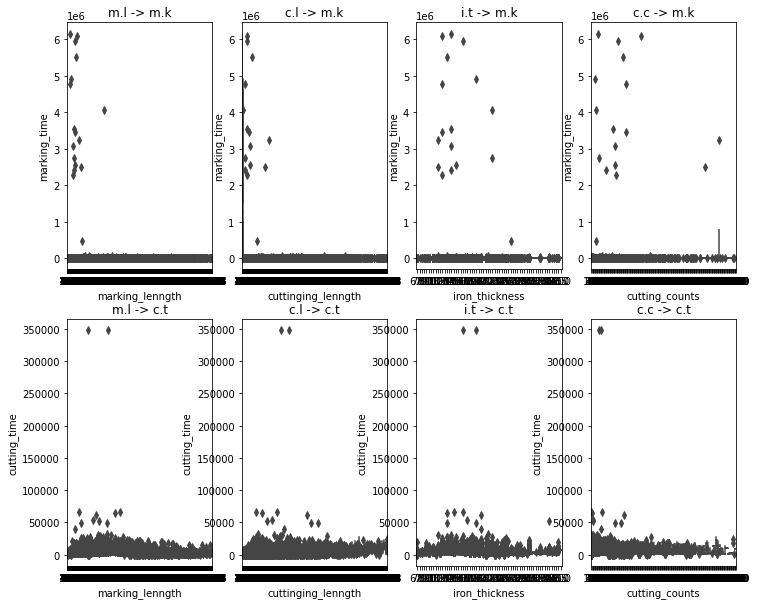

In [15]:
# 변수가 기온에 미치는 수준 시각화

fig, axes = plt.subplots(nrows=2,ncols=4)
fig.set_size_inches(12, 10)
sns.boxplot(data=data,y="C9",x="C2",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="C9",x="C3",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="C9",x="C4",orient="v",ax=axes[0][2])
sns.boxplot(data=data,y="C9",x="C6",orient="v",ax=axes[0][3])
sns.boxplot(data=data,y="C10",x="C2",orient="v",ax=axes[1][0])
sns.boxplot(data=data,y="C10",x="C3",orient="v",ax=axes[1][1])
sns.boxplot(data=data,y="C10",x="C4",orient="v",ax=axes[1][2])
sns.boxplot(data=data,y="C10",x="C6",orient="v",ax=axes[1][3])

axes[0][0].set(xlabel='marking_lenngth', ylabel='marking_time',title="m.l -> m.k")
axes[0][1].set(xlabel='cuttinging_lenngth', ylabel='marking_time',title="c.l -> m.k")
axes[0][2].set(xlabel='iron_thickness', ylabel='marking_time',title="i.t -> m.k")
axes[0][3].set(xlabel='cutting_counts', ylabel='marking_time',title="c.c -> m.k")
axes[1][0].set(xlabel='marking_lenngth', ylabel='cutting_time',title="m.l -> c.t")
axes[1][1].set(xlabel='cuttinging_lenngth', ylabel='cutting_time',title="c.l -> c.t")
axes[1][2].set(xlabel='iron_thickness', ylabel='cutting_time',title="i.t -> c.t")
axes[1][3].set(xlabel='cutting_counts', ylabel='cutting_time',title="c.c -> c.t")

In [16]:
data.corr()

,C2,C3,C4,C6,C7,C9,C10
C2,1.000000,0.070781,0.044351,-0.159683,0.043453,-0.006975,0.047683
C3,0.070781,1.000000,-0.236533,0.689220,-0.015098,-0.007704,0.678733
C4,0.044351,-0.236533,1.000000,-0.281155,0.013745,-0.006285,-0.017149
C6,-0.159683,0.689220,-0.281155,1.000000,-0.048700,0.016234,0.470813
C7,0.043453,-0.015098,0.013745,-0.048700,1.000000,-0.005554,-0.018434
C9,-0.006975,-0.007704,-0.006285,0.016234,-0.005554,1.000000,-0.003566
C10,0.047683,0.678733,-0.017149,0.470813,-0.018434,-0.003566,1.000000


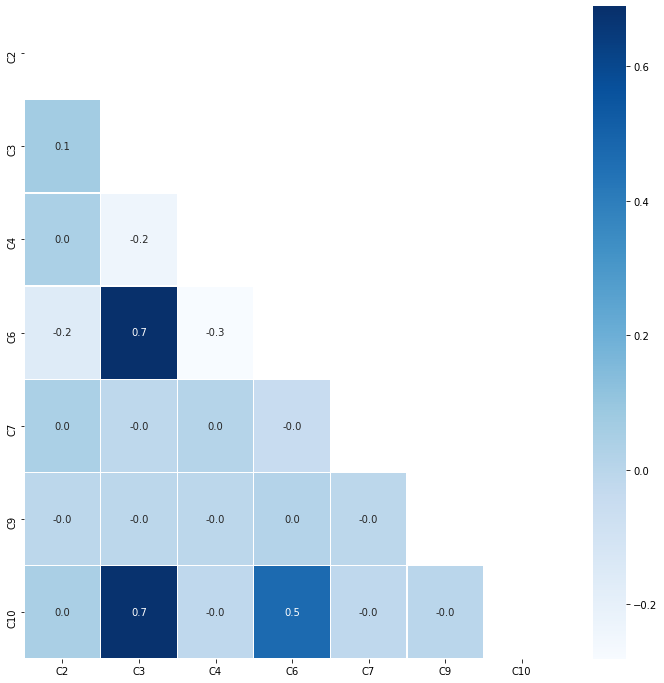

In [17]:
f, ax = plt.subplots(figsize=(12,12))
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), annot=True, linewidths=0.4, linecolor='white', fmt='.1f', ax=ax, cmap='Blues', mask=mask)
plt.show()

* c1(작업번호)에 대해서는 역시나 상관성이 통일하게 0으로 나타나고 있다. 해당 피쳐를 모델링시에는 삭제해주기로 한다.
* 절단길이-절단수, 절단길이-절단시간이 0.7정도의 상관성을 보이고 있다.
* 절단수-절단시간 사이에서도 0.5의 상관성을 보이고 있다.
* 그외에는 크게 상관성을 갖고있지 않다
  * 특히나 절단시간 외의 또 다른 타겟값인 마킹시간에 대해서는 다른피쳐와 상관성이 아예 없다시피해서 아쉬운결과를 보여주고 있다

## 3. 데이터 전처리
* 필요에 따라서 정규화 시키기 (하는경우를 정확히 알아두기. 그리고 eda후에 시각화 하는게 맞는듯. 안그러면 eda보기 너무 불편함)
* 이상치탐색이랑, 삭제피처, 정규화 등으로 최종 전처리 이후 시각화 한번 더 간단하게 몇개 해주고
* 피처 몇개는 범주형으로 취급 카테고리 ㅇㅇ. 



### 이상치 탐색을 위한 데이터 분석

In [18]:
from collections import Counter
def detect_outliers(df,features):
  outlier_indices = [] #이상치(특이값) 찾아주는거
  for c in features:
    Q1 = np.percentile(df[c],25)
    Q3 = np.percentile(df[c],75)
    IQR = Q3 - Q1
    outlier_step = IQR * 1.5
    outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index #filtre
    outlier_indices.extend(outlier_list_col)
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2) 
  return multiple_outliers

In [19]:
# 이상치 출력
data.loc[detect_outliers(data,["C2","C3","C4","C6","C9","C10"])]
# 이상치 제거 후 새 df 출력
data = data.drop(detect_outliers(data,["C2","C3","C4","C6","C9","C10"]))
data

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
1,1,46.0,21.9,30.0,DZB,1.0,23.0,PL233,194.0,827.0
2,2,33.9,111.8,12.0,A,46.0,23.0,PL233,324.0,2906.0
3,3,49.5,33.5,13.0,A,2.0,23.0,PL234,241.0,1003.0
4,4,75.7,174.9,13.0,A,35.0,23.0,PL233,483.0,4412.0
5,5,66.5,66.6,13.0,A,7.0,23.0,PL233,331.0,1601.0
...,...,...,...,...,...,...,...,...,...,...
162321,162337,139.8,162.0,19.0,AH32,31.0,23.0,PL231,827.0,2899.0
162322,162338,18.5,28.9,16.0,A,56.0,25.0,PL252,165.0,930.0
162323,162339,63.7,25.6,15.0,AH32,1.0,26.0,PL261,345.0,696.0
162324,162340,94.7,61.4,19.0,AH32,2.0,26.0,PL261,0.0,2155.0


# 여기서부터는 모르겠습니다 !!!

### 범주형 데이터 처리를 위한 인코딩 

In [20]:
onehot = pd.get_dummies(data, columns = ['C5','C7','C8'])
data = pd.concat([data, onehot], axis=1)
data.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C1,C2,C3,C4,C6,C9,C10,C5_32M60C,C5_460F32MS,C5_9NI,C5_A,C5_AA,C5_AAH32,C5_AAH32-TM,C5_AAH36,C5_AE,C5_AEH32-TM,C5_AH32,C5_AH32-TM,C5_AH32TL,C5_AH36,C5_AH36-TM,C5_AH36TL,C5_AH40-TM,C5_B,C5_BA,C5_BAH32,C5_BAH36,C5_BZ,C5_BZB,...,C7_21.0,C7_22.0,C7_23.0,C7_24.0,C7_25.0,C7_26.0,C7_27.0,C7_91.0,C7_92.0,C7_96.0,C7_97.0,C8_PL141,C8_PL142,C8_PL211,C8_PL212,C8_PL221,C8_PL223,C8_PL224,C8_PL231,C8_PL233,C8_PL234,C8_PL241,C8_PL242,C8_PL252,C8_PL253,C8_PL254,C8_PL261,C8_PL262,C8_PL271,C8_PL272,C8_PL273,C8_PL911,C8_PL921,C8_PL922,C8_PL961,C8_PL973,C8_PL974,C8_PS213,C8_PS243,C8_PS963
1,1,46.0,21.9,30.0,DZB,1.0,23.0,PL233,194.0,827.0,1,46.0,21.9,30.0,1.0,194.0,827.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,33.9,111.8,12.0,A,46.0,23.0,PL233,324.0,2906.0,2,33.9,111.8,12.0,46.0,324.0,2906.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,49.5,33.5,13.0,A,2.0,23.0,PL234,241.0,1003.0,3,49.5,33.5,13.0,2.0,241.0,1003.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,75.7,174.9,13.0,A,35.0,23.0,PL233,483.0,4412.0,4,75.7,174.9,13.0,35.0,483.0,4412.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,66.5,66.6,13.0,A,7.0,23.0,PL233,331.0,1601.0,5,66.5,66.6,13.0,7.0,331.0,1601.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 최종 전처리 이후 상관성 분석

In [21]:
data.corr()

,C2,C3,C4,C6,C7,C9,C10,C2,C3,C4,C6,C9,C10,C5_32M60C,C5_460F32MS,C5_9NI,C5_A,C5_AA,C5_AAH32,C5_AAH32-TM,C5_AAH36,C5_AE,C5_AEH32-TM,C5_AH32,C5_AH32-TM,C5_AH32TL,C5_AH36,C5_AH36-TM,C5_AH36TL,C5_AH40-TM,C5_B,C5_BA,C5_BAH32,C5_BAH36,C5_BZ,C5_BZB,C5_D,C5_D-TM,C5_DH32,C5_DH32-TM,...,C7_21.0,C7_22.0,C7_23.0,C7_24.0,C7_25.0,C7_26.0,C7_27.0,C7_91.0,C7_92.0,C7_96.0,C7_97.0,C8_PL141,C8_PL142,C8_PL211,C8_PL212,C8_PL221,C8_PL223,C8_PL224,C8_PL231,C8_PL233,C8_PL234,C8_PL241,C8_PL242,C8_PL252,C8_PL253,C8_PL254,C8_PL261,C8_PL262,C8_PL271,C8_PL272,C8_PL273,C8_PL911,C8_PL921,C8_PL922,C8_PL961,C8_PL973,C8_PL974,C8_PS213,C8_PS243,C8_PS963
C2,1.000000,0.070738,0.047666,-0.211744,0.045575,-0.007260,0.038554,1.000000,0.070738,0.047666,-0.211744,-0.007260,0.038554,-0.009055,-0.003745,-0.004374,0.056958,-0.002190,-0.003413,0.001793,-0.003348,0.001093,0.002851,-0.055179,-0.056971,-0.008299,-0.023174,-0.014416,-0.004098,-0.007293,0.004599,-0.001158,0.009228,-0.003698,-0.000335,0.001540,0.035212,0.006042,0.052099,0.033549,...,0.006852,-0.088089,-0.045691,0.003974,-0.052503,-0.072325,0.251038,0.048112,0.075355,-0.054035,-0.049473,-0.076578,-0.082242,0.039332,0.042475,-0.023602,-0.106520,-0.033945,0.012333,-0.046078,-0.039461,0.033154,0.036283,-0.141991,0.017251,0.012875,-0.024988,-0.078487,0.128763,0.146383,0.139042,0.048112,0.047951,0.054535,-0.038655,-0.036758,-0.032021,-0.063490,-0.062689,-0.037031
C3,0.070738,1.000000,-0.254873,0.536444,-0.006291,-0.009843,0.574958,0.070738,1.000000,-0.254873,0.536444,-0.009843,0.574958,0.010259,-0.003081,0.011371,0.093078,0.002307,-0.002986,-0.003173,-0.003722,0.001309,-0.000917,-0.036045,-0.081883,-0.008761,-0.042860,-0.001428,-0.004543,0.001160,0.002075,0.004625,-0.002405,-0.003124,-0.001307,-0.004183,-0.007289,-0.001283,-0.021448,-0.034524,...,0.099219,0.078851,0.192657,0.094195,-0.020260,-0.008636,-0.183781,-0.076785,-0.097513,0.098081,0.099373,-0.120398,-0.128982,0.058664,0.062253,0.083349,-0.045145,0.072027,0.127012,0.101214,0.096969,0.047345,0.071732,-0.119042,0.029915,0.032498,0.018922,-0.033559,-0.098854,-0.102017,-0.102472,-0.076785,-0.067599,-0.065045,0.084319,0.068405,0.070418,0.047369,0.038119,0.050453
C4,0.047666,-0.254873,1.000000,-0.298483,0.013232,-0.006430,0.002203,0.047666,-0.254873,1.000000,-0.298483,-0.006430,0.002203,-0.121752,0.006990,-0.034862,-0.281891,-0.001171,0.005625,0.005065,0.012002,-0.004201,0.001395,0.223511,0.100670,0.037820,0.176824,0.026384,0.014633,0.011061,-0.025238,-0.005765,0.003416,0.004752,0.001395,0.014953,-0.029118,0.005871,0.025858,0.148283,...,-0.033280,-0.057403,-0.073066,-0.047945,-0.039758,-0.016577,0.109335,-0.032731,0.084089,-0.054066,-0.006896,0.065809,0.068409,-0.020997,0.003674,-0.024876,-0.060075,-0.019803,-0.037517,-0.044598,-0.040246,-0.024394,-0.029342,-0.065563,-0.010131,-0.001565,0.001726,-0.026219,0.052847,0.057429,0.069467,-0.032731,0.055170,0.059202,-0.065972,0.002645,-0.013194,-0.038011,-0.026783,-0.004727
C6,-0.211744,0.536444,-0.298483,1.000000,-0.050707,0.020262,0.306228,-0.211744,0.536444,-0.298483,1.000000,0.020262,0.306228,0.028515,-0.000240,0.008971,0.109310,0.002057,-0.004654,-0.004154,-0.001726,-0.000535,-0.001570,-0.076377,-0.084758,-0.003584,-0.038694,-0.014577,-0.000757,0.001979,-0.012637,0.008851,-0.003605,-0.000535,-0.001422,-0.008025,0.015015,-0.001127,-0.010666,-0.030654,...,0.044463,0.136489,0.110454,0.030795,0.153185,0.072173,-0.187683,-0.079207,-0.097339,0.055307,0.045829,-0.127322,-0.133238,0.012812,0.016751,0.036877,0.190010,0.034415,0.056250,0.068605,0.060093,0.000153,0.015767,0.293674,0.003098,0.005977,0.000256,0.105571,-0.096715,-0.113146,-0.100047,-0.079207,-0.067195,-0.065213,0.045426,0.032634,0.031253,0.043473,0.034831,0.030961
C7,0.045575,-0.006291,0.013232,-0.050707,1.000000,-0.005653,-0.011114,0.045575,-0.006291,0.013232,-0.050707,-0.005653,-0.011114,0.043386,0.003641,-0.028023,0.028073,0.004585,0.002884,-0.003872,-0.001183,-0.001785,-0.001397,-0.026243,-0.025502,0.004363,-0.000712,0.007058,0.005806,0.003737,-0.020482,0.00831

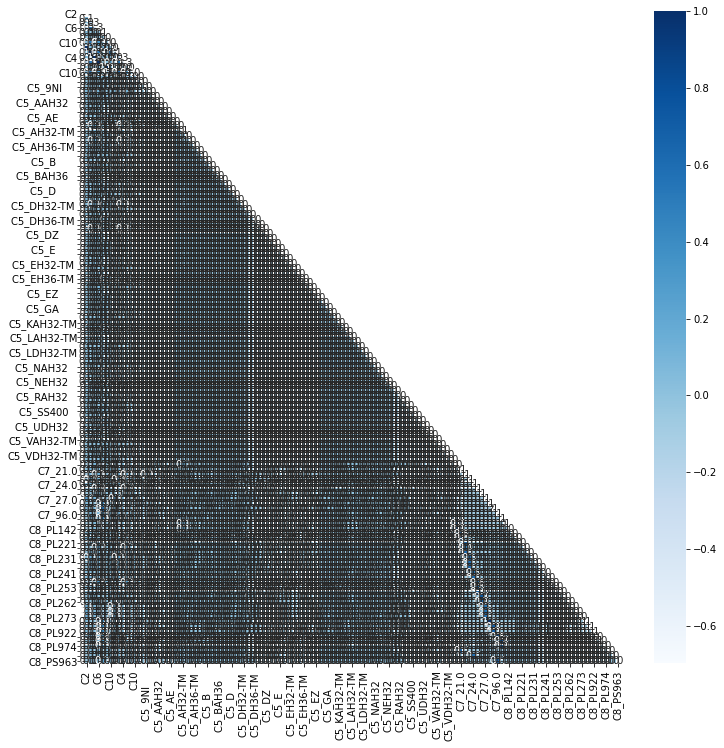

In [22]:
f, ax = plt.subplots(figsize=(12,12))
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), annot=True, linewidths=0.4, linecolor='white', fmt='.1f', ax=ax, cmap='Blues', mask=mask)
plt.show()

In [23]:
'''g = sns.factorplot(x = "key", y = "popularity", data = song_data, kind = "bar", size = 6)
g.set_ylabels("Popularity Probability")
plt.show()'''
# 변수에 위 과정에서 수더 커진거 하나정도 그림 더 그린다 이정도로만 하기

'g = sns.factorplot(x = "key", y = "popularity", data = song_data, kind = "bar", size = 6)\ng.set_ylabels("Popularity Probability")\nplt.show()'

## 4. 머신러닝 알고리즘 적합형태로 데이터 준비 
* 선정되고 수정한 피쳐들을 x로 만들고 y만빼서 y로 만들어주기
* 사이킷런 스플릿으로 트레인이랑 테스트 나누어주기

In [43]:
# C9예측(마킹시간 예측)
y1 = data['C9']
x1 = data.drop(['C1', 'C9'], axis=1) # 원하는 항목 지워서 x 넣기
# C10예측(절단시간 예측)
y2 = data['C10']
x2 = data.drop(['C1', 'C10'], axis=1) # 원하는 항목 지워서 x 넣기

In [45]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1,y1)
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2,y2)

In [46]:
X_test1.shape

(39283, 133)

In [47]:
X_test2.shape

(39283, 133)

In [41]:
y_test1.shape

(39283, 2)

,C9,C9
73452,321.0,321.0
33440,257.0,257.0
118864,277.0,277.0
73233,952.0,952.0
100461,182.0,182.0


## 5. 알고리즘 적용 
* model = model명()
* model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

### 선형회귀

In [ ]:
model = LinearRegression()
model.fit(X1_train, y1_train)
predict = model.predict(X1_test)
print(f"마킹시간rmse : {np.sqrt(mean_squared_error(y1_test, predict))}")
model.fit(X2_train, y2_train)
predict = model.predict(X2_test)
print(f"절단시간rmse : {np.sqrt(mean_squared_error(y2_test, predict))}")

### 랜덤포레스트

In [ ]:
model = RandomForestRegressor()
model.fit(X1_train, y1_train)
predict = model.predict(X1_test)
print(f"root_mean_squared_error : {np.sqrt(mean_squared_error(y1_test, predict))}")
model.fit(X2_train, y2_train)
predict = model.predict(X2_test)
print(f"절단시간rmse : {np.sqrt(mean_squared_error(y2_test, predict))}")

### SVM

In [ ]:
svm = SVR()
svm.fit(X1_train, y1_train)
predict = model.predict(X1_test)
print(f"root_mean_squared_error : {np.sqrt(mean_squared_error(y1_test, predict))}")
model.fit(X2_train, y2_train)
predict = model.predict(X2_test)
print(f"절단시간rmse : {np.sqrt(mean_squared_error(y2_test, predict))}")

## 6. 결과 평가 
* rmsle나 rmse 써서 오차에 대한 수준을 파악해서 최종 알고리즘 선정.
* 검증은 교차검증방법 (k fold) 써서 오버피팅 등에 따른 입력변수 및 알고리즘 개선 작업 ㄱㄱ 

### 방법메모
1. 수가 커졌다 작아졌다 오차 들쭉날쭉 하면 로그 쓰셈 아니면 보기좋으니까 rmsle말고 rmse 쓰는듯
2. .score는 단순 정확도 나타내는 내장함수인듯 -> 이거의 단점은 분류시간에 말한 정확도 단점이랑 같은듯 (레이블의 편향될경우 틀린다는거)
3. 검증 (단순평가 말고 과적합, 과소적합에 판단하는거 인듯) 할때 k fold 쓴다. 테스트랑 트레인 나누고 마지막에 이거 교차검증을 통해서 평균 검증정확도 이런거를 알구 이런거에 따른 알고리즘 조정을 하게한다 -> 벗 위에서 알고리즘 선정시 유사한 점수로 갈린다면 스플릿으로 선정된 레이블 값이 편향가졌을수도 있으니까 k fold로도 알고리즘 선정할수있을듯!
** https://homeproject.tistory.com/entry/%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D-cross-validation 여기참고

In [ ]:
'''score = cross_val_score(선정모델명, X1_train, y1_train, cv=5)
print('교차검증 평균 : %.3f' %(score.mean()))'''
'''score = cross_val_score(선정모델명, X2_train, y2_train, cv=5)
print('교차검증 평균 : %.3f' %(score.mean()))'''

## 7. 알고리즘 개선
* svm 같은거 입력변수 조절로 가능하다 

## 8. 원하는 결과 나올때까지 반복작업 